In [1]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
USERNAME = 'dryu'
PWD = 'VRyrf4cXDtccxT4b'
DB_HOST = [('olympus','olympus.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
           ,('atlas','atlas.ctbsm6jecdy0.us-west-2.redshift.amazonaws.com')
          ,('verizon','rr.verizon.amer-ignite.digitalturbine.com')]

In [3]:
conn_olympus = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                                f"dbname={DB_HOST[0][0]} host={DB_HOST[0][1]}")
conn_atlas = psycopg2.connect(f"user={USERNAME} password={PWD} port = 5439 "
                              f"dbname={DB_HOST[1][0]} host={DB_HOST[1][1]}")
cur_olympus = conn_olympus.cursor()
cur_atlas = conn_atlas.cursor()


In [4]:
query = """
select 
    b.name
    , campaign_id 
    , bid_price_per_download
from venus.campaign_dimension c 
join venus.billing_type_lookup b
    on c.billing_type_id = b.id
where
    status_id = 5
group by 1,2,3
"""

In [5]:
cur_olympus.execute(query)
df = pd.DataFrame(cur_olympus.fetchall(), columns = [c[0] for c in cur_olympus.description])

In [6]:
df.bid_price_per_download = df.bid_price_per_download.astype('float')
bid_price = df[df.name != 'CPC'].pivot_table(values = 'bid_price_per_download',index = 'campaign_id',columns = 'name', aggfunc = 'mean')
ax = bid_price.boxplot()
ax.set_ylim(0,5)
ax.set_title('Bid Rates for active campaigns')

Text(0.5, 1.0, 'Bid Rates for active campaigns')

In [7]:
ax = bid_price.boxplot()
ax.set_title('Bid Rates for active campaigns')
ax.set_ylim(0,.15)

(0.0, 0.15)

Text(0.5, 0.98, 'Bid Rates for active CPP vs. CPI campaigns')

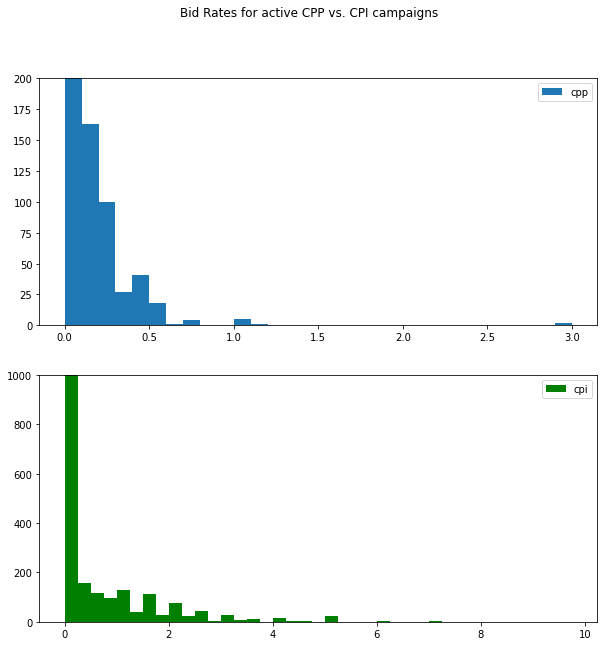

In [8]:
cpp_bids = df.loc[df.name == 'CPP','bid_price_per_download']
cpi_bids = df.loc[df.name == 'CPI','bid_price_per_download']
fig, ax = plt.subplots(2,1,figsize = (10,10))
ax[0].hist(cpp_bids, bins=np.arange(min(cpp_bids), max(cpp_bids)+.1,.1),label = 'cpp')
ax[0].set_ylim(0,200)
ax[0].legend()
ax[1].hist(cpi_bids, bins=np.arange(min(cpi_bids), 10,.25),color = 'green', label = 'cpi')
ax[1].set_ylim(0,1000)
ax[1].legend()
fig.suptitle('Bid Rates for active CPP vs. CPI campaigns')

In [9]:
query_cvr = """
    select 
        date(ctp.tracking_time) as preload_date
        , ctp.campaign_id 
        , count(distinct ctp.reqid) as preloads
        , count(distinct cti.reqid) as installs
    from rawdata.campaign_tracking_active_preload ctp 
    join rawdata.campaign c 
        on ctp.campaign_id = c.campaign_id 
        and c.billing_type_id = 1
        and c.campaign_name not like '%House'
    left join rawdata.campaign_tracking_active_install cti 
        on ctp.site_id = cti.site_id
        and ctp.reqid = cti.reqid 
        and datediff('day',ctp.tracking_time,cti.tracking_time) < 7
        and date(cti.tracking_time) >= date('02-17-2020')
        and date(cti.tracking_time) < current_date
    where
        date(ctp.tracking_time) < current_date - interval '7' day 
        and date(ctp.tracking_time) >= date('02-17-2020')
    group by 1,2
"""

In [10]:
cur_atlas.execute(query_cvr)
df_cvr = pd.DataFrame(cur_atlas.fetchall(), columns = [c[0] for c in cur_atlas.description])

In [11]:
plt.scatter(df_cvr['preloads'], df_cvr['installs'])
m, b = np.polyfit(df_cvr['preloads'], df_cvr['installs'],1)
plt.plot(df_cvr['preloads'],m*df_cvr['preloads']+b)
plt.plot(df_cvr['preloads'],1.2*m*df_cvr['preloads']+b)
plt.plot(df_cvr['preloads'],.8*m*df_cvr['preloads']+b)
plt.xlabel('preloads')
plt.ylabel('installs')
plt.title('Preloads/Installs per day/campaign')
print('Mid: installs = ',str(round(m,3)),'x preloads +',str(round(b,3)))
print('Hi: installs = ',str(round(1.2*m,3)),'x preloads +',str(round(b,3)))
print('Lo: installs = ',str(round(.8*m,3)),'x preloads +',str(round(b,3)))

Mid: installs =  0.149 x preloads + 30.042
Hi: installs =  0.179 x preloads + 30.042
Lo: installs =  0.119 x preloads + 30.042


In [108]:
df_cvr[df_cvr.cvr == 0].sort_values('preloads',ascending=False).head(30)

preload_date  campaign_id  preloads  installs  cvr
88193    2020-10-09        26147   2830290         0  0.0
176096   2020-10-09        21443   2814033         0  0.0
58943    2020-10-09        22530   2787056         0  0.0
185879   2020-10-09        19014   2313303         0  0.0
88185    2020-10-09        19019   2280405         0  0.0
176094   2020-10-09        19016   2241335         0  0.0
68656    2020-10-09        19018   2239878         0  0.0
156497   2020-10-09        29199   2094439         0  0.0
215140   2020-10-09        19017    591120         0  0.0
185843   2020-10-08        29199    366514         0  0.0
146455   2020-10-08        26147    316933         0  0.0
39321    2020-10-08        21443    279266         0  0.0
68579    2020-10-08        22530    253894         0  0.0
10033    2020-10-08        19014    226910         0  0.0
19797    2020-10-08        19018    222242         0  0.0
156424   2020-10-08        19019    188428         0  0.0
64439    2020-12-25        30966    187726         0  0.0
73925    2020-12-25        27146    183782         0  0.0
19796    2020-10-08        19016    183071         0  0.0
203792   2021-02-05        22530    152086         0  0.0
125420   2021-02-05        26147    147135         0  0.0
135198   2021-02-05        21443    145076         0  0.0
78172    2020-10-09        24962    143678         0  0.0
88124    2020-10-08        19017    136069         0  0.0
232992   2021-01-30        29352    133280         0  0.0
95574    2021-01-23        29352    127530         0  0.0
105702   2021-01-29        29352    122161         0  0.0
164623   2021-02-04        22530    121785         0  0.0
145064   2021-02-05        19019    121183         0  0.0
203803   2021-02-05        29199    120748         0  0.0